In [1]:
import torch
import numpy as np
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

from evaluation_based_sampling import evaluate, evaluate_program
from daphne import daphne

from graph_based_sampling import sample_from_joint

## Problem 5
I approach this problem with approximate Baysean computation. Relaxing the dirac into a normal. This is inspired by the definition of the dirac as a normal pdf in the limit of the variance going to zero. 
  * Khuri, A. I. (2004). Applications of Dirac’s delta function in statistics. International Journal of Mathematical Education in Science and Technology, 35(2), 185–195. http://doi.org/10.1080/00207390310001638313

I set the variance of the normal to $0.1^2$ more detailed study could be done showing the behaviour as a function of the variance. At $\sigma^2 <= 0.03^2$ I encoutered errors in HMC, likely caused by things going to infinity (log_prob scoring was out of distribution, and it is normal... ?)

## Comments on ABC for this problem
There are really only one degree of freedom for this problem, since when one value is fixed, the other must be seven minus it, to be compatible with the observe statement `(observe (dirac (+ x y)) 7)`. So there is only one variance, and no covariance. In the ABC approximation however, we only strictly enforce that $x + y = 7$ and thus we get a covariance of x and y.

Any $x+y=7$ is compatible with the observe, and this "manifold" is the line. The ABC makes this line have non-zero measure.

Another way to do this problem, would be to incorporate the observe into the program, and replace y with 7-x somehow to enforce the constraint. 

## Comparison of IS, MH Gibbs & HMC
* IS. has high variance, but gets reasonable means of near 3.5
* Gibbs is still and so can't update very well. It is exploring along a very narrow ridge, instead of along the line. x and y should be updated together as a block. The problem is very stiff (the dicar makes it initifely stiff).
* HMC has variance near IS. We can see from the joint that it is converging with iterations gradually.

## Error trace 
for normal that is too narrow (intentionally put below)

```python
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
/var/folders/bg/cb0cr7ls61352lhy50167r0c0000gn/T/ipykernel_58709/4110678344.py in <module>
      1 num_samples=28000//10
----> 2 return_list, samples_whole_graph = hmc_wrapper(graph,num_samples,T=40,epsilon=0.1)

~/repos/prob_prog/hw/hw3/hmc.py in hmc_wrapper(graph, num_samples, T, epsilon, M)
     33         # include kinetic and potential energy functions
     34         # MC acceptance criteria
---> 35     samples_whole_graph = hmc_algo20(X0,num_samples,T,epsilon,M,Y,P,X_vertex_names_to_idx_d)
     36 
     37     # evaluate samples (on whatever function, here the return of the program) as needed

~/repos/prob_prog/hw/hw3/hmc.py in hmc_algo20(X0, num_samples, T, epsilon, M, Y, P, X_vertex_names_to_idx_d)
     56     for s in range(num_samples):
     57         R_s = normal_R_reuse.sample()
---> 58         R_p, X_p = leapfrog(copy.deepcopy(X_s),copy.deepcopy(R_s),T,epsilon,Y,P,X_vertex_names_to_idx_d)
     59         # X_p, R_p = leapfrog(X_s,R_s,T,epsilon,X_vertex_names_to_idx_d)
     60             # copy X_s?

~/repos/prob_prog/hw/hw3/hmc.py in leapfrog(X0, R0, T, epsilon, Y, P, X_vertex_names_to_idx_d)
     83         # TODO: save all in loop instead of overwriting to visualize
     84         X_t = add_dict_to_tensor(X_t,epsilon*R_t,X_vertex_names_to_idx_d)
---> 85         R_t = R_t - epsilon*grad_U(X_t,Y,P,X_vertex_names_to_idx_d)
     86     X_T = add_dict_to_tensor(X_t,epsilon*R_t,X_vertex_names_to_idx_d)
     87     R_T = R_t - epsilon_2*grad_U(X_T,Y,P,X_vertex_names_to_idx_d)

~/repos/prob_prog/hw/hw3/hmc.py in grad_U(X, Y, P, X_vertex_names_to_idx_d)
    112     return vector of gradients
    113     """
--> 114     energy_U = compute_U(X,Y,P)
    115 
    116     # Zero the gradients.

~/repos/prob_prog/hw/hw3/hmc.py in compute_U(X, Y, P)
    177 
    178 def compute_U(X,Y,P):
--> 179     energy_U = -compute_log_joint_prob(X,Y,P)
    180     return energy_U
    181 

~/repos/prob_prog/hw/hw3/hmc.py in compute_log_joint_prob(X, Y, P)
    167         e = P[X_vertex][1]
    168         distribution = evaluate(e,local_env=X)[0]
--> 169         log_prob += score(distribution,X[X_vertex])
    170     for Y_vertex in Y.keys():
    171         e = P[Y_vertex][1]

~/repos/prob_prog/hw/hw3/evaluation_based_sampling.py in score(distribution, c)
     55         log_w = distribution.log_prob(c.double())
     56     else:
---> 57         log_w = distribution.log_prob(c)
     58     return log_w
     59 

~/miniconda2/envs/prob_prog/lib/python3.9/site-packages/torch/distributions/normal.py in log_prob(self, value)
     71     def log_prob(self, value):
     72         if self._validate_args:
---> 73             self._validate_sample(value)
     74         # compute the variance
     75         var = (self.scale ** 2)

~/miniconda2/envs/prob_prog/lib/python3.9/site-packages/torch/distributions/distribution.py in _validate_sample(self, value)
    275         assert support is not None
    276         if not support.check(value).all():
--> 277             raise ValueError('The value argument must be within the support')
    278 
    279     def _get_checked_instance(self, cls, _instance=None):

ValueError: The value argument must be within the support
```

In [2]:
from load_helper import ast_helper, graph_helper

### Importance sampling
30k in 10s implies 1.698 million

In [3]:
import parse
import importance_sampling
import importlib
importlib.reload(parse)

<module 'parse' from '/Users/gw/repos/prob_prog/hw/hw3/parse.py'>

In [4]:
fname = '5_abc.daphne' 
ast = ast_helper(fname)
ast

[['let',
  ['x', ['sample', ['normal', 0, 10]]],
  ['let',
   ['y', ['sample', ['normal', 0, 10]]],
   ['let',
    ['dontcare0', ['observe', ['normal', ['+', 'x', 'y'], 0.09], 7]],
    ['vector', 'x', 'y']]]]]

In [5]:
%%time
num_samples=int(1.698e6)
samples, sigmas = parse.take_samples(num_samples,ast=ast)
samples = np.array([sample.tolist() for sample in samples])

CPU times: user 9min 37s, sys: 2.48 s, total: 9min 40s
Wall time: 9min 40s


In [6]:
posterior_mean, probs = importance_sampling.weighted_average(samples,sigmas,reshape_probs=(-1,1),axis=0)
posterior_mean

array([3.53386895, 3.46580443])

Text(0.5, 0, 'slope')

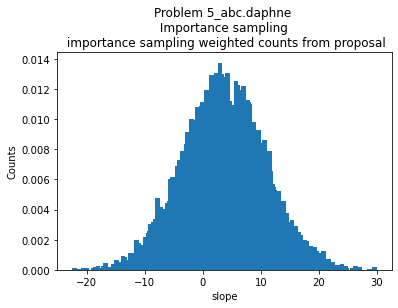

In [7]:
counts_bins = np.histogram(samples[:,0], weights=probs[:,0], bins=500)
counts, bins = counts_bins[0], counts_bins[1]
idx = (counts > counts.max()*0.005)
plt.bar(bins[1:][idx],counts[idx])
plt.title('Problem {} \n Importance sampling \n importance sampling weighted counts from proposal'.format(fname))
plt.ylabel('Counts')
plt.xlabel('slope')

Text(0.5, 0, 'bias')

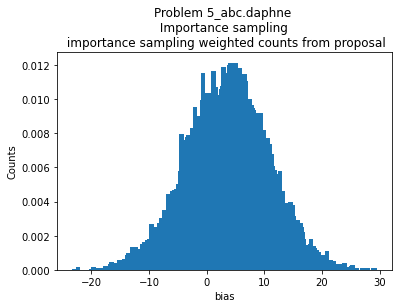

In [8]:
counts_bins = np.histogram(samples[:,1], weights=probs[:,0], bins=500)
counts, bins = counts_bins[0], counts_bins[1]
idx = (counts > counts.max()*0.005)
plt.bar(bins[1:][idx],counts[idx])
plt.title('Problem {} \n Importance sampling \n importance sampling weighted counts from proposal'.format(fname))
plt.ylabel('Counts')
plt.xlabel('bias')

In [9]:
expectation_samples_2, probs = importance_sampling.weighted_average(samples**2,sigmas,reshape_probs=(-1,1),axis=0) 
posterior_variance = expectation_samples_2 - posterior_mean**2
posterior_variance

array([49.98343282, 49.98004001])

In [10]:
expectation_samplex_sampley, probs = importance_sampling.weighted_average(samples[:,0]*samples[:,1],sigmas) 
covariance = expectation_samplex_sampley - posterior_mean[0]*posterior_mean[1]
covariance

-49.9777814630405

In [11]:
for result in [
    "{} Importance sampling: posterior mean slope {:1.3f} | variance slope {:1.3e}".format(fname,posterior_mean[0],posterior_variance[0]),
    "{} Importance sampling: posterior mean bias {:1.3f} | variance bias {:1.3e}".format(fname,posterior_mean[1],posterior_variance[1]),
    "{} Importance sampling: posterior covariance of slope and bias variance bias {:1.3e}".format(fname,covariance),
    
]:
    print(result)

5_abc.daphne Importance sampling: posterior mean slope 3.534 | variance slope 4.998e+01
5_abc.daphne Importance sampling: posterior mean bias 3.466 | variance bias 4.998e+01
5_abc.daphne Importance sampling: posterior covariance of slope and bias variance bias -4.998e+01


Numpy contains it's own method for computing this, and we can check it agrees with our results (where things are spelt out a bit more for learning purposes).

In [12]:
np.cov(samples.T,aweights=probs,ddof=0)

array([[ 49.98343282, -49.97778146],
       [-49.97778146,  49.98004001]])

### MH Gibbs
14k in 22.8s implies 368k in 10 min

In [13]:
import mh_gibbs 
from hmc import hmc_wrapper, compute_log_joint_prob
importlib.reload(mh_gibbs)

<module 'mh_gibbs' from '/Users/gw/repos/prob_prog/hw/hw3/mh_gibbs.py'>

In [14]:
fname = '5_abc.daphne' 
graph = graph_helper(fname)
graph

[{},
 {'V': ['observe3', 'sample2', 'sample1'],
  'A': {'sample2': ['observe3'], 'sample1': ['observe3']},
  'P': {'sample1': ['sample*', ['normal', 0, 10]],
   'sample2': ['sample*', ['normal', 0, 10]],
   'observe3': ['observe*', ['normal', ['+', 'sample1', 'sample2'], 0.09], 7]},
  'Y': {'observe3': 7}},
 ['vector', 'sample1', 'sample2']]

In [15]:
%%time
num_steps=368000
return_list, samples_whole_graph = mh_gibbs.mh_gibbs_wrapper(graph,num_steps)
samples = np.array([sample.tolist() for sample in return_list])

CPU times: user 9min 48s, sys: 1.51 s, total: 9min 49s
Wall time: 9min 50s


In [16]:
samples = np.array([sample.tolist() for sample in return_list])

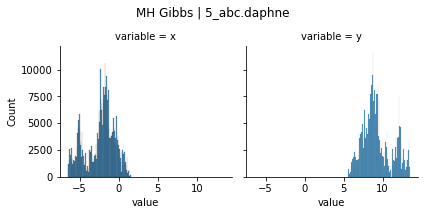

In [17]:
burn_in = int(0.01*num_steps)
df = pd.DataFrame(samples[burn_in:])
df.columns = ['x','y']
df['iteration'] = df.index
tall = pd.melt(df, id_vars='iteration')

g = sns.FacetGrid(tall, col="variable")
g.map(sns.histplot, "value")

plt.suptitle('MH Gibbs | {}'.format(fname))
plt.subplots_adjust(top=0.8)

In [18]:
posterior_mean = samples[burn_in:].mean(0)
cov_matrix = np.cov(samples[burn_in:].T,ddof=0)
posterior_variance = samples[burn_in:].var(0)
covariance = cov_matrix[0,1]
assert np.isclose(cov_matrix[0,0],posterior_variance[0])
assert np.isclose(cov_matrix[1,1],posterior_variance[1])

In [19]:
for result in [
    "{} MH Gibbs: posterior mean slope {:1.3f} | variance slope {:1.3e}".format(fname,posterior_mean[0],posterior_variance[0]),
    "{} MH Gibbs: posterior mean bias {:1.3f} | variance bias {:1.3e}".format(fname,posterior_mean[1],posterior_variance[1]),
    "{} MH Gibbs: posterior covariance of slope and bias variance bias {:1.3e}".format(fname,covariance),
    
]:
    print(result)

5_abc.daphne MH Gibbs: posterior mean slope -2.343 | variance slope 3.465e+00
5_abc.daphne MH Gibbs: posterior mean bias 9.342 | variance bias 3.465e+00
5_abc.daphne MH Gibbs: posterior covariance of slope and bias variance bias -3.461e+00


Text(0.5, 0.98, '5_abc.daphne | MH Gibbs \n Sample trace')

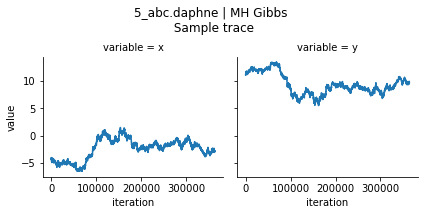

In [20]:
g = sns.FacetGrid(tall, col="variable")
g.map(plt.plot, "iteration","value")

plt.suptitle('MH Gibbs | {}'.format(fname))
plt.subplots_adjust(top=0.75)
plt.suptitle('{} | MH Gibbs \n Sample trace'.format(fname))

In [21]:
G = graph[1]
Y = G['Y']
Y = {key:evaluate([value])[0] for key,value in Y.items()}
P = G['P']

In [22]:
size = len(samples_whole_graph)
jll = np.zeros(size)
for idx in range(size):
    jll[idx] = compute_log_joint_prob(samples_whole_graph[idx],Y,P)

Text(0.5, 1.0, '5_abc.daphne | MH Gibbs \n Joint density')

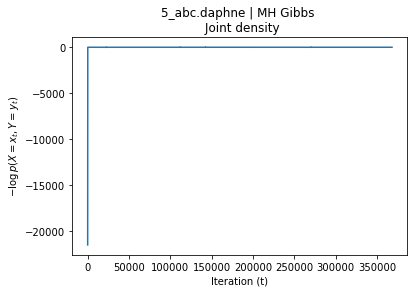

In [23]:
pd.Series(jll).plot()
plt.xlabel('Iteration (t)')
plt.ylabel(r'$-\log p(X=x_t,Y=y_t)$')
plt.title('{} | MH Gibbs \n Joint density'.format(fname))

### HMC
* 0.56k in 16.2s implies 20.7k in 10 min

In [24]:
fname = '5_abc.daphne' 
graph = graph_helper(fname)
graph

[{},
 {'V': ['observe3', 'sample2', 'sample1'],
  'A': {'sample2': ['observe3'], 'sample1': ['observe3']},
  'P': {'sample1': ['sample*', ['normal', 0, 10]],
   'sample2': ['sample*', ['normal', 0, 10]],
   'observe3': ['observe*', ['normal', ['+', 'sample1', 'sample2'], 0.09], 7]},
  'Y': {'observe3': 7}},
 ['vector', 'sample1', 'sample2']]

In [25]:
import hmc
importlib.reload(hmc)
from hmc import hmc_wrapper

In [26]:
%%time
num_samples=20700
return_list, samples_whole_graph = hmc_wrapper(graph,num_samples,T=40,epsilon=0.1)

CPU times: user 9min 40s, sys: 1.46 s, total: 9min 42s
Wall time: 9min 43s


In [27]:
samples = np.array([sample.tolist() for sample in return_list])

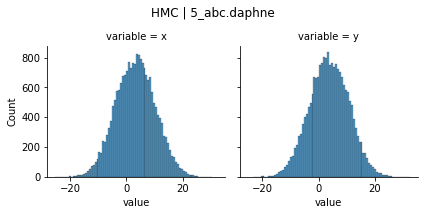

In [28]:
burn_in = int(0.01*num_samples)
df = pd.DataFrame(samples[burn_in:])
df.columns = ['x','y']
df['iteration'] = df.index
tall = pd.melt(df, id_vars='iteration')

g = sns.FacetGrid(tall, col="variable")
g.map(sns.histplot, "value")

plt.suptitle('HMC | {}'.format(fname))
plt.subplots_adjust(top=0.8)


In [29]:
posterior_mean = samples[burn_in:].mean(0)
cov_matrix = np.cov(samples[burn_in:].T,ddof=0)
posterior_variance = samples[burn_in:].var(0)
covariance = cov_matrix[0,1]
assert np.isclose(cov_matrix[0,0],posterior_variance[0])
assert np.isclose(cov_matrix[1,1],posterior_variance[1])

In [30]:
for result in [
    "{} HMC: posterior mean slope {:1.3f} | variance slope {:1.3e}".format(fname,posterior_mean[0],posterior_variance[0]),
    "{} HMC: posterior mean bias {:1.3f} | variance bias {:1.3e}".format(fname,posterior_mean[1],posterior_variance[1]),
    "{} HMC: posterior covariance of slope and bias variance bias {:1.3e}".format(fname,covariance),
    
]:
    print(result)

5_abc.daphne HMC: posterior mean slope 3.279 | variance slope 4.787e+01
5_abc.daphne HMC: posterior mean bias 3.721 | variance bias 4.788e+01
5_abc.daphne HMC: posterior covariance of slope and bias variance bias -4.739e+01


Text(0.5, 0.98, '5_abc.daphne | HMC \n Sample trace')

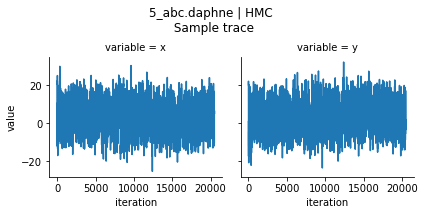

In [31]:
g = sns.FacetGrid(tall, col="variable")
g.map(plt.plot, "iteration","value")

plt.suptitle('HMC | {}'.format(fname))
plt.subplots_adjust(top=0.75)
plt.suptitle('{} | HMC \n Sample trace'.format(fname))

In [32]:
G = graph[1]
Y = G['Y']
Y = {key:evaluate([value])[0] for key,value in Y.items()}
P = G['P']

In [33]:
size = len(samples_whole_graph)
jll = np.zeros(size)
for idx in range(size):
    jll[idx] = compute_log_joint_prob(samples_whole_graph[idx],Y,P)

Text(0.5, 1.0, '5_abc.daphne | HMC \n Joint density')

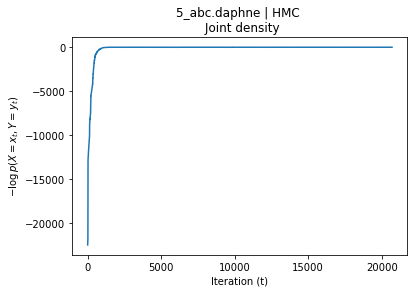

In [34]:
pd.Series(jll).plot()
plt.xlabel('Iteration (t)')
plt.ylabel(r'$-\log p(X=x_t,Y=y_t)$')
plt.title('{} | HMC \n Joint density'.format(fname))